<a href="https://colab.research.google.com/github/MxFxM/ColabCodes/blob/master/Pytorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title MNIST Neural Network

#@markdown ### Link to tutorial

# https://youtu.be/ixathu7U-LQ

#@markdown ---
#@markdown ### Getting the datasets

"""
For this example the MNIST dataset is used.
"""

import torch
import torchvision
from torchvision import transforms, datasets

# since datasets do not come in tensor form, a transformation has to take place
train = datasets.MNIST('', train = True, download = True,
                       transform = transforms.Compose([
                                                       transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train = False, download = True,
                      transform = transforms.Compose([
                                                      transforms.ToTensor()
                      ]))

trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = True)
testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = False)

#@markdown ---
#@markdown ### The neural net

import torch.nn as nn # as classes => object oriented programming
import torch.nn.functional as F # as a function

class Net(nn.Module): # the neural network as a class with Module as parent

    def __init__(self):
        super().__init__() # run the init of the parent class with super
        self.fc1 = nn.Linear(28*28, 64) # (size) input, output
        self.fc2 = nn.Linear(64, 64) # this makes a fully connected layer (linear)
        self.fc3 = nn.Linear(64, 64) # this does not yet define the order
        self.fc4 = nn.Linear(64, 10) # 10 output classes (0, 1, ..., 9)

    def forward(self, x):
        # this now sets the order of the layers
        x = F.relu(self.fc1(x)) # x passes through the first layer
        x = F.relu(self.fc2(x)) # then x is passed to and then through the second layer
        x = F.relu(self.fc3(x)) # and so on. also notice relu activation function
        x = self.fc4(x) # here we dont want relu
        # there could be a test in between layers
        # for example continue on layer a if temperature > 10 else continue on layer b
        return F.log_softmax(x, dim=1) # softmax over last layer on first dimension

net = Net()
print(net)

X = torch.rand((28, 28)) # a random 28 x 28 matrix, could be a random picture

"""
# this would throw a size missmatch error because the net expectts a flattend image
output = net(X) # is the same as net.forward(X) because net is child of torch Module
"""

"""
# this also doesn't run because the shape is not correctly set
X = X.view(28 * 28) # this flattens the image by "looking" at it as if it were one long array
output = net(X)
"""

X = X.view(-1, 28 * 28) # the -1 says, that the shape is unknown
# since we know the shappe is exactly what is expected (here)
# there tecnically could also be a 1,28*28 but this is more general
output = net(X)
print(output)

# what is missing?
# - randomly initialized weights
# - a "real" input
# - handling of the output
#   - a real prediction
#   - learning

#@markdown ---
#@markdown ### Optimizer

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=1e-3) # net.parameters are all changeable weights etc

#@markdown ---
#@markdown ### Training

EPOCHS = 3 # number of full passes over the data set

from tqdm import tqdm # progress bar

for epoch in range(EPOCHS):
    for data in tqdm(trainset): # data is a batch of features and labels
        X, y = data # unpack
        """
        print(y) # this is a batch
        break
        """
        net.zero_grad() # reset old gradient(s), in this case for every batch
        output = net(X.view(-1, 28*28)) # put through nn
        loss = F.nll_loss(output, y) # how far off were we?
        # for one hot encoding [0, 0, 1, 0, 0, 0, 0] use mean squared error
        loss.backward() # ez
        optimizer.step()
    print(f"Loss: {loss}")

#@markdown ---
#@markdown ### Testing

correct = 0
total = 0

with torch.no_grad(): # no gradients while testing!
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print(f"Accuracy: {round(correct/total, 3)}")

#@markdown ---
#@markdown ### Visualize result

import matplotlib.pyplot as plt

plt.imshow(X[0].view(28, 28))
plt.show()
print(torch.argmax(net(X[0].view(-1, 28*28))[0]))

plt.imshow(X[1].view(28, 28))
plt.show()
print(torch.argmax(net(X[1].view(-1, 28*28))[0]))

plt.imshow(X[2].view(28, 28))
plt.show()
print(torch.argmax(net(X[2].view(-1, 28*28))[0]))

In [0]:
#@title Cats vs Dogs, Convolutional Neural Network

#@markdown ---
#@markdown ### Get the dataset

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

#@markdown ---
#@markdown ### Extract the zip file

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#@markdown ---
#@markdown ### Prepare links to directories

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#@markdown ---
#@markdown ### Prepare training data

import os
import cv2
import numpy as np
from tqdm import tqdm # this is used for progess bars

from google.colab.patches import cv2_imshow # colab only

REBUILD_DATA = True # Run preprocessing only once

class DogsVSCats():
    IMG_SIZE = 50 # 50x50 images, no varying size or shape
    LABELS = {train_cats_dir: 0, train_dogs_dir: 1} # index: cat = 0, dog = 1
    training_data = []
    catcount = 0 # for balance
    dogcount = 0 # for balance

    def make_training_data(self):
        for f in tqdm(os.listdir(train_cats_dir)): # for every file in directory # this is used for progess bars
            try:
                path = os.path.join(train_cats_dir, f) # path to file
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert to grayscale
                # ask yourself: is color a relevant feature to determine wheter it's a cat or a dog?
                #cv2_imshow(img)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[train_cats_dir]]])
                # make one hot vectors using np.eye()) => einheitsmatrix (diagonale mit 1er)
                # cut the row needed using np.eye(m)[n]
                # with n as the index of the active value
                # and m the number of possibilities
                self.catcount += 1
            except Exception as e:
                pass
        for f in tqdm(os.listdir(train_dogs_dir)): # for every file in directory # this is used for progess bars
            try:
                path = os.path.join(train_dogs_dir, f) # path to file
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert to grayscale
                # ask yourself: is color a relevant feature to determine wheter it's a cat or a dog?
                #cv2_imshow(img)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[train_dogs_dir]]])
                # make one hot vectors using np.eye()) => einheitsmatrix (diagonale mit 1er)
                # cut the row needed using np.eye(m)[n]
                # with n as the index of the active value
                # and m the number of possibilities
                self.dogcount += 1
            except Exception as e:
                pass
        print(f"\nBalance:  Cats {self.catcount} | Dogs {self.dogcount}")
        np.random.shuffle(self.training_data) # shuffles in place, so no training data = ... necessary
        #np.save("training_data.npy", self.training_data)

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

training_data = dogsvscats.training_data
#training_data = np.load("training_data.npy", allow_pickle=True)

#@markdown ---
#@markdown ### Build the model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # input, output, kernel_size
        self.conv2 = nn.Conv2d(32, 64, 5) # input, output, kernel_size
        self.conv3 = nn.Conv2d(64, 128, 5) # input, output, kernel_size
        # there are 1d and 3d convolutional layers
        # 1d can be used for sequential data
        # "input is 1 2d image, it outputs 32 feature rich output images"

        # self.fc1 = nn.Linear(???, 512) # we don't really know the shape of the output so we need to test it
        # self.fc2 = nn.Linear(512, 2)

        x = torch.randn(50, 50).view(-1, 1, 50, 50) # create a fake image
        self._to_linear = None
        self.convs(x) # only the convolution part of the forwarding

        self.fc1 = nn.Linear(self._to_linear, 512) # now we know
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # pooling and relu(ing)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None: # only once
            print()
            print(x[0].shape)
            print()
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2] # find shape of output, x[0] because x is a batch
        
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # flatten with the now known shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) # softmax for 2 classes (cat / dog), dim is necessary because it's batched
        return x
    
net = Net()

#@markdown ---
#@markdown ### Prepare optimizer

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss() # mean squared error

#@markdown ---
#@markdown ### Split data for test and train

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0 # scale between 0 and 1
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # percent of data to be for validation
val_size = int(len(X) * VAL_PCT)
print(f"Validation Size: {val_size}\n")

train_X = X[:-val_size] # up to negative val size = sliceing
train_y = y[:-val_size]

test_X = X[-val_size:] # negative val size onward
test_y = y[-val_size:]

#@markdown ---
#@markdown ### Train the model

BATCH_SIZE = 100 # if memeory error, change batch size (>1 please, if still, reduce layers etc)
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # nice progress bar
        # print(i, i + BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print()
    print(loss)


#@markdown ---
#@markdown ### Test the accuracy

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct = correct + 1
        total = total + 1
print()
print(f"Accuracy: {round(correct/total, 3)}")

In [0]:
#@title Cats vs Dogs, Convolutional Neural Network AGAIN but GPU (CUDA)

#@markdown ---
#@markdown ### Test for a CUDA enabled device

import torch

print(f"CUDA: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Running on: {device}")

# torch.cuda.device_count()
print()

#@markdown ---
#@markdown ### Get the dataset

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

#@markdown ---
#@markdown ### Extract the zip file

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#@markdown ---
#@markdown ### Prepare links to directories

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#@markdown ---
#@markdown ### Prepare training data

import os
import cv2
import numpy as np
from tqdm import tqdm # this is used for progess bars

from google.colab.patches import cv2_imshow # colab only

REBUILD_DATA = True # Run preprocessing only once

class DogsVSCats():
    IMG_SIZE = 50 # 50x50 images, no varying size or shape
    LABELS = {train_cats_dir: 0, train_dogs_dir: 1} # index: cat = 0, dog = 1
    training_data = []
    catcount = 0 # for balance
    dogcount = 0 # for balance

    def make_training_data(self):
        for f in tqdm(os.listdir(train_cats_dir)): # for every file in directory # this is used for progess bars
            try:
                path = os.path.join(train_cats_dir, f) # path to file
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert to grayscale
                # ask yourself: is color a relevant feature to determine wheter it's a cat or a dog?
                #cv2_imshow(img)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[train_cats_dir]]])
                # make one hot vectors using np.eye()) => einheitsmatrix (diagonale mit 1er)
                # cut the row needed using np.eye(m)[n]
                # with n as the index of the active value
                # and m the number of possibilities
                self.catcount += 1
            except Exception as e:
                pass
        for f in tqdm(os.listdir(train_dogs_dir)): # for every file in directory # this is used for progess bars
            try:
                path = os.path.join(train_dogs_dir, f) # path to file
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert to grayscale
                # ask yourself: is color a relevant feature to determine wheter it's a cat or a dog?
                #cv2_imshow(img)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[train_dogs_dir]]])
                # make one hot vectors using np.eye()) => einheitsmatrix (diagonale mit 1er)
                # cut the row needed using np.eye(m)[n]
                # with n as the index of the active value
                # and m the number of possibilities
                self.dogcount += 1
            except Exception as e:
                pass
        print(f"\nBalance:  Cats {self.catcount} | Dogs {self.dogcount}")
        np.random.shuffle(self.training_data) # shuffles in place, so no training data = ... necessary
        #np.save("training_data.npy", self.training_data)

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

training_data = dogsvscats.training_data
#training_data = np.load("training_data.npy", allow_pickle=True)

#@markdown ---
#@markdown ### Build the model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # input, output, kernel_size
        self.conv2 = nn.Conv2d(32, 64, 5) # input, output, kernel_size
        self.conv3 = nn.Conv2d(64, 128, 5) # input, output, kernel_size
        # there are 1d and 3d convolutional layers
        # 1d can be used for sequential data
        # "input is 1 2d image, it outputs 32 feature rich output images"

        # self.fc1 = nn.Linear(???, 512) # we don't really know the shape of the output so we need to test it
        # self.fc2 = nn.Linear(512, 2)

        x = torch.randn(50, 50).view(-1, 1, 50, 50) # create a fake image
        self._to_linear = None
        self.convs(x) # only the convolution part of the forwarding

        self.fc1 = nn.Linear(self._to_linear, 512) # now we know
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # pooling and relu(ing)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None: # only once
            print()
            print(x[0].shape)
            print()
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2] # find shape of output, x[0] because x is a batch
        
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # flatten with the now known shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) # softmax for 2 classes (cat / dog), dim is necessary because it's batched
        return x

net = Net().to(device) # this does the magic
# the net is now on the GPU but the data not yet

#@markdown ---
#@markdown ### Prepare optimizer

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss() # mean squared error

#@markdown ---
#@markdown ### Split data for test and train

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0 # scale between 0 and 1
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # percent of data to be for validation
val_size = int(len(X) * VAL_PCT)
print(f"Validation Size: {val_size}\n")

train_X = X[:-val_size] # up to negative val size = sliceing
train_y = y[:-val_size]

test_X = X[-val_size:] # negative val size onward
test_y = y[-val_size:]

#@markdown ---
#@markdown ### Train the model

BATCH_SIZE = 200 # if memeory error, change batch size (>1 please, if still, reduce layers etc)
EPOCHS = 50

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # nice progress bar
        # print(i, i + BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    # print()
    # print(loss)


#@markdown ---
#@markdown ### Test the accuracy

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0] # note that this also runs on the GPU
        predicted_class = torch.argmax(net_out).to(torch.device("cpu")) # get the output back to compare it, alternatively put real_class on GPU
        if predicted_class == real_class:
            correct = correct + 1
        total = total + 1
print()
print(f"Accuracy: {round(correct/total, 3)}")


correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(train_X))):
        real_class = torch.argmax(train_y[i])
        net_out = net(train_X[i].view(-1, 1, 50, 50).to(device))[0] # note that this also runs on the GPU
        predicted_class = torch.argmax(net_out).to(torch.device("cpu")) # get the output back to compare it, alternatively put real_class on GPU
        if predicted_class == real_class:
            correct = correct + 1
        total = total + 1
print()
print(f"Overfit: In train Accuracy: {round(correct/total, 3)}")

By using GPU acceleration:

Train iterations per second is *18

Test iterations per second is *2

CUDA: True
Running on: cuda:0

--2019-10-17 20:48:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  83.0MB/s    in 0.8s    

2019-10-17 20:48:47 (83.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



 22%|██▏       | 2/9 [00:00<00:00, 13.24it/s]


Balance:  Cats 1000 | Dogs 1000
Validation Size: 200

model-1571345340

torch.Size([128, 2, 2])

0.46875 tensor(1.6773, device='cuda:0')
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


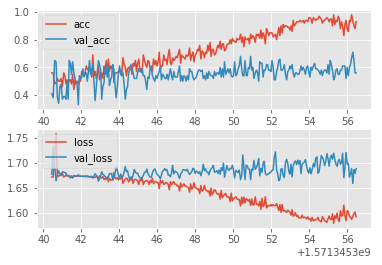

In [0]:
#@title Cats vs Dogs, Convolutional Neural Network AGAIN but GPU (CUDA) and with model evaluation

#@markdown ---
#@markdown ### Test for a CUDA enabled device

import torch

print(f"CUDA: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(f"Running on: {device}")

# torch.cuda.device_count()
print()

#@markdown ---
#@markdown ### Get the dataset

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

#@markdown ---
#@markdown ### Extract the zip file

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

#@markdown ---
#@markdown ### Prepare links to directories

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

#@markdown ---
#@markdown ### Prepare training data

import os
import cv2
import numpy as np
from tqdm import tqdm # this is used for progess bars

from google.colab.patches import cv2_imshow # colab only

REBUILD_DATA = True # Run preprocessing only once

class DogsVSCats():
    IMG_SIZE = 50 # 50x50 images, no varying size or shape
    LABELS = {train_cats_dir: 0, train_dogs_dir: 1} # index: cat = 0, dog = 1
    training_data = []
    catcount = 0 # for balance
    dogcount = 0 # for balance

    def make_training_data(self):
        for f in tqdm(os.listdir(train_cats_dir)): # for every file in directory # this is used for progess bars
            try:
                path = os.path.join(train_cats_dir, f) # path to file
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert to grayscale
                # ask yourself: is color a relevant feature to determine wheter it's a cat or a dog?
                #cv2_imshow(img)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[train_cats_dir]]])
                # make one hot vectors using np.eye()) => einheitsmatrix (diagonale mit 1er)
                # cut the row needed using np.eye(m)[n]
                # with n as the index of the active value
                # and m the number of possibilities
                self.catcount += 1
            except Exception as e:
                pass
        for f in tqdm(os.listdir(train_dogs_dir)): # for every file in directory # this is used for progess bars
            try:
                path = os.path.join(train_dogs_dir, f) # path to file
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # convert to grayscale
                # ask yourself: is color a relevant feature to determine wheter it's a cat or a dog?
                #cv2_imshow(img)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), np.eye(2)[self.LABELS[train_dogs_dir]]])
                # make one hot vectors using np.eye()) => einheitsmatrix (diagonale mit 1er)
                # cut the row needed using np.eye(m)[n]
                # with n as the index of the active value
                # and m the number of possibilities
                self.dogcount += 1
            except Exception as e:
                pass
        print(f"\nBalance:  Cats {self.catcount} | Dogs {self.dogcount}")
        np.random.shuffle(self.training_data) # shuffles in place, so no training data = ... necessary
        #np.save("training_data.npy", self.training_data)

if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

training_data = dogsvscats.training_data
#training_data = np.load("training_data.npy", allow_pickle=True)

#@markdown ---
#@markdown ### Build the model

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) # input, output, kernel_size
        self.conv2 = nn.Conv2d(32, 64, 5) # input, output, kernel_size
        self.conv3 = nn.Conv2d(64, 128, 5) # input, output, kernel_size
        # there are 1d and 3d convolutional layers
        # 1d can be used for sequential data
        # "input is 1 2d image, it outputs 32 feature rich output images"

        # self.fc1 = nn.Linear(???, 512) # we don't really know the shape of the output so we need to test it
        # self.fc2 = nn.Linear(512, 2)

        x = torch.randn(50, 50).view(-1, 1, 50, 50) # create a fake image
        self._to_linear = None
        self.convs(x) # only the convolution part of the forwarding

        self.fc1 = nn.Linear(self._to_linear, 512) # now we know
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # pooling and relu(ing)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None: # only once
            print()
            print(x[0].shape)
            print()
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2] # find shape of output, x[0] because x is a batch
        
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # flatten with the now known shape
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1) # softmax for 2 classes (cat / dog), dim is necessary because it's batched
        return x

"""
net = Net().to(device) # this does the magic
# the net is now on the GPU but the data not yet
"""

"""
#markdown ---
#markdown ### Prepare optimizer

import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss() # mean squared error
"""

#@markdown ---
#@markdown ### Split data for test and train

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X / 255.0 # scale between 0 and 1
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # percent of data to be for validation
val_size = int(len(X) * VAL_PCT)
print(f"Validation Size: {val_size}\n")

train_X = X[:-val_size] # up to negative val size = sliceing
train_y = y[:-val_size]

test_X = X[-val_size:] # negative val size onward
test_y = y[-val_size:]

"""
#markdown ---
#markdown ### Train the model

BATCH_SIZE = 200 # if memeory error, change batch size (>1 please, if still, reduce layers etc)
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # nice progress bar
        # print(i, i + BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50).to(device)
        batch_y = train_y[i:i+BATCH_SIZE].to(device)
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
    # print()
    # print(loss)
"""

"""
#markdown ---
#markdown ### Test the accuracy

correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0] # note that this also runs on the GPU
        predicted_class = torch.argmax(net_out).to(torch.device("cpu")) # get the output back to compare it, alternatively put real_class on GPU
        if predicted_class == real_class:
            correct = correct + 1
        total = total + 1
print()
print(f"Accuracy: {round(correct/total, 3)}")


correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(train_X))):
        real_class = torch.argmax(train_y[i])
        net_out = net(train_X[i].view(-1, 1, 50, 50).to(device))[0] # note that this also runs on the GPU
        predicted_class = torch.argmax(net_out).to(torch.device("cpu")) # get the output back to compare it, alternatively put real_class on GPU
        if predicted_class == real_class:
            correct = correct + 1
        total = total + 1
print()
print(f"Overfit?: In train Accuracy: {round(correct/total, 3)}")
print()
"""

#@markdown ---
#@markdown ### Updated model

import time
import torch.optim as optim

MODEL_NAME = f"model-{int(time.time())}"

print(MODEL_NAME)
net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss() # mean squared error

#@markdown ---
#@markdown ### Updated pass with model evaluation tracking possible

def fwd_pass(X, y, train=False):
    X = X.to(device)
    y = y.to(device)
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)] # how many predictions are right
    acc = matches.count(True) / len(matches) # percentage of right answers
    loss = loss_function(outputs, y)
    if train:
        loss.backward()
        optimizer.step()
    return acc, loss

#@markdown ---
#@markdown ### Test the accuracy on a random slice of the test data

def test(size=32):
    random_start = np.random.randint(len(test_X)-size) # get random samples (but in order) from test
    X, y = test_X[random_start:random_start + size], test_y[random_start:random_start + size]
    with torch.no_grad():
        val_acc, val_loss = fwd_pass(X.view(-1,1,50,50), y) # pass without train
    return val_acc, val_loss

val_acc, val_loss = test()
print(val_acc, val_loss)

#@markdown ---
#@markdown ### Updated training function

def train(BATCH_SIZE, EPOCHS):
    from google.colab import drive
    drive.mount('/content/gdrive') # to save on drive

    with open("/content/gdrive/My Drive/Colab Notebooks/model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50) # to device is done in forward pass
                batch_y = train_y[i:i+BATCH_SIZE] # to device is done in forward pass
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True) # train enabled
                
                if i % 50 == 0: # every 50 steps
                    val_acc, val_loss = test(size=100) # test it
                    f.write(f"{MODEL_NAME},{round(time.time(), 3)},{round(float(acc), 2)},{round(float(loss), 4)},{round(float(val_acc), 2)},{round(float(val_loss), 4)}, {epoch}, {i}\n")

#@markdown ---
#@markdown ### Function to plot training results

def show_log(name=""):
    if name != "":
        from google.colab import drive
        drive.mount('/content/gdrive') # to save on drive
        import matplotlib.pyplot as plt
        from matplotlib import style
        style.use("ggplot")

        # %matplotlib notebook
        # only in jupyter

        contents = open("/content/gdrive/My Drive/Colab Notebooks/model.log", "r").read().split("\n")
        times = []
        accuracies = []
        losses = []
        val_accuracies = []
        val_losses = []

        for c in contents:
            if name in c:
                model_name, timestamp, acc, loss, val_acc, val_loss, epoch, step = c.split(",")
                times.append(float(timestamp))
                accuracies.append(float(acc))
                losses.append(float(loss))
                val_accuracies.append(float(val_acc))
                val_losses.append(float(val_loss))
        
        fig = plt.figure()
        
        ax1 = plt.subplot2grid((2,1), (0, 0))
        ax2 = plt.subplot2grid((2,1), (1, 0), sharex=ax1)
        
        ax1.plot(times, accuracies, label="acc")
        ax1.plot(times, val_accuracies, label="val_acc")
        ax1.legend(loc=2)

        ax2.plot(times, losses, label="loss")
        ax2.plot(times, val_losses, label="val_loss")
        ax2.legend(loc=2)

        plt.show()

#@markdown ---
#@markdown ### Train and show results

train(200, 30)
show_log(MODEL_NAME)